--- Starting Federated Training ---

--- Federated Round 1/4 ---
  Training client D1...
  Training client D2...
  Training client D3...
  Training client D4...
  Training client D5...
  Aggregating client models...
  Evaluating global model on test sets after aggregation...
    Client Test Dataset D1 - Acc: 0.7179, F1: 0.6589, AUC: 0.9687376725838265
    Client Test Dataset D2 - Acc: 0.5750, F1: 0.4813, AUC: 0.98
    Client Test Dataset D3 - Acc: 0.7179, F1: 0.6589, AUC: 0.9687376725838265
    Client Test Dataset D4 - Acc: 0.9565, F1: 0.9554, AUC: 0.9954729094028446
    Client Test Dataset D5 - Acc: 0.9455, F1: 0.9450, AUC: 1.0

--- Federated Round 2/4 ---
  Training client D1...
  Training client D2...
  Training client D3...
  Training client D4...
  Training client D5...
  Aggregating client models...
  Evaluating global model on test sets after aggregation...
    Client Test Dataset D1 - Acc: 0.9087, F1: 0.9070, AUC: 0.981634889327197
    Client Test Dataset D2 - Acc: 0.8750, F1: 

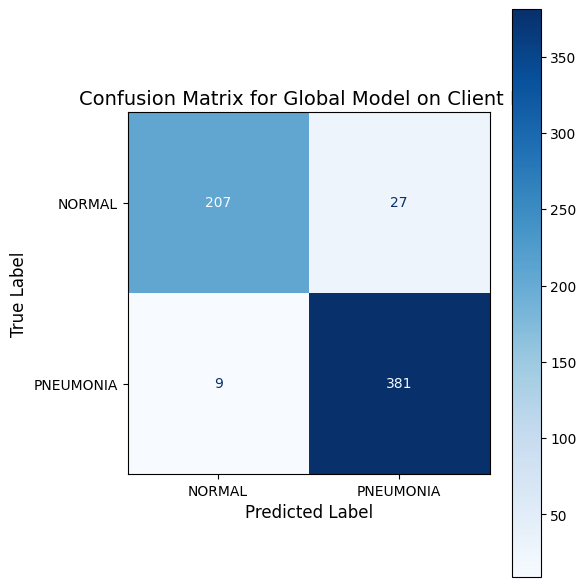

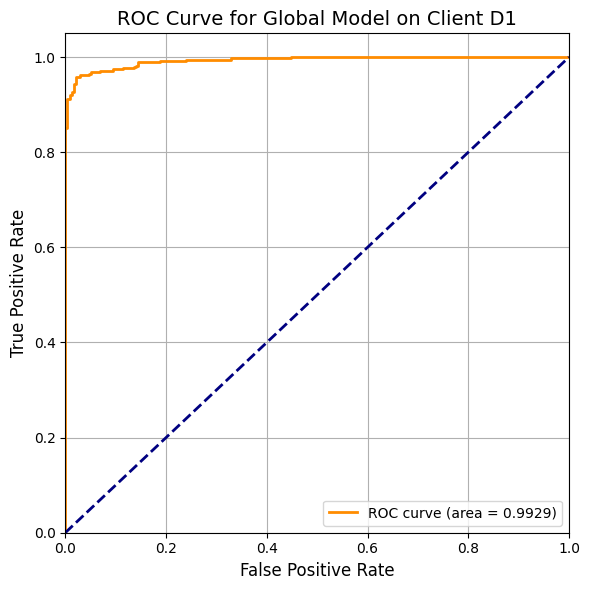


Evaluating final global model on Client D2

Classification Report:
              precision  recall  f1-score  support
NORMAL         0.933333   0.700  0.800000   20.000
PNEUMONIA      0.760000   0.950  0.844444   20.000
accuracy       0.825000   0.825  0.825000    0.825
macro avg      0.846667   0.825  0.822222   40.000
weighted avg   0.846667   0.825  0.822222   40.000


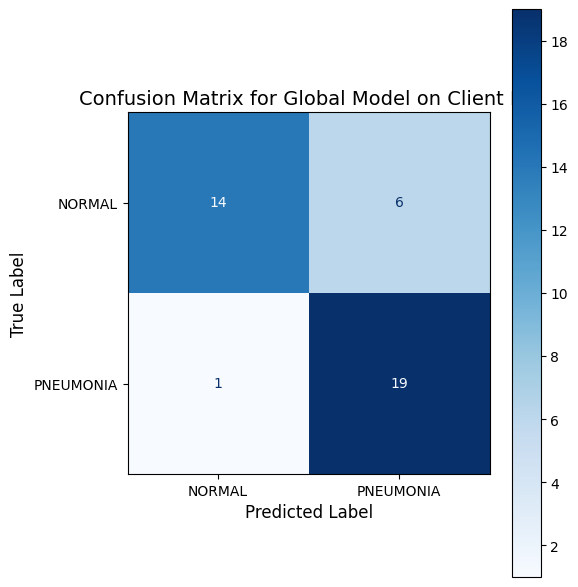

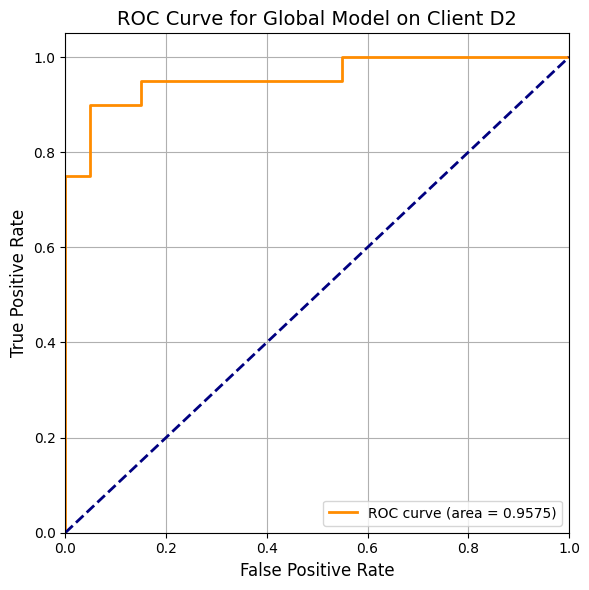


Evaluating final global model on Client D3

Classification Report:
              precision    recall  f1-score     support
NORMAL         0.958333  0.884615  0.920000  234.000000
PNEUMONIA      0.933824  0.976923  0.954887  390.000000
accuracy       0.942308  0.942308  0.942308    0.942308
macro avg      0.946078  0.930769  0.937444  624.000000
weighted avg   0.943015  0.942308  0.941805  624.000000


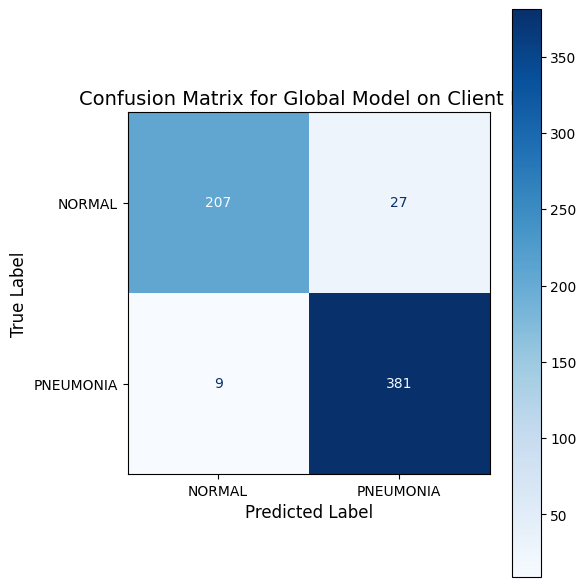

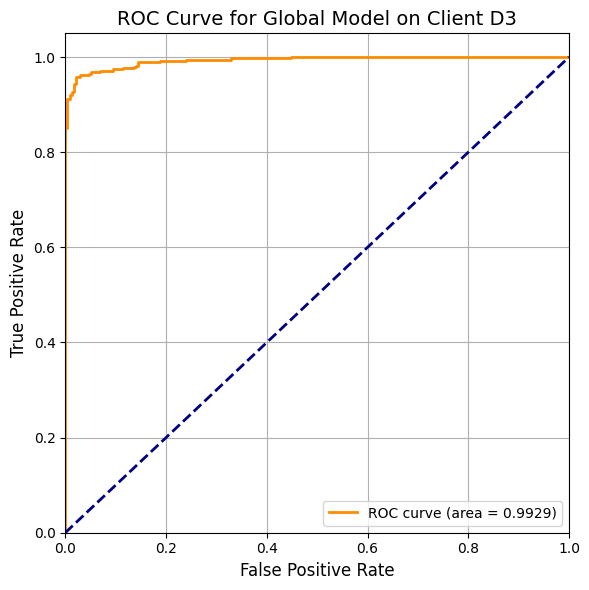


Evaluating final global model on Client D4

Classification Report:
              precision    recall  f1-score      support
NORMAL         0.892958  1.000000  0.943452   317.000000
PNEUMONIA      1.000000  0.955556  0.977273   855.000000
accuracy       0.967577  0.967577  0.967577     0.967577
macro avg      0.946479  0.977778  0.960363  1172.000000
weighted avg   0.971047  0.967577  0.968125  1172.000000


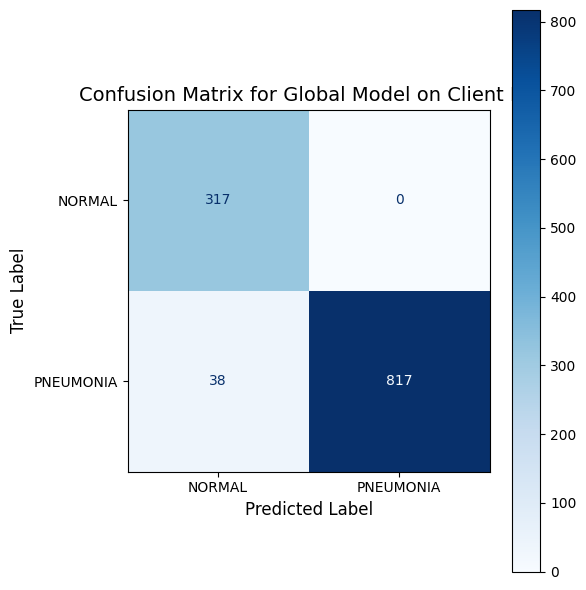

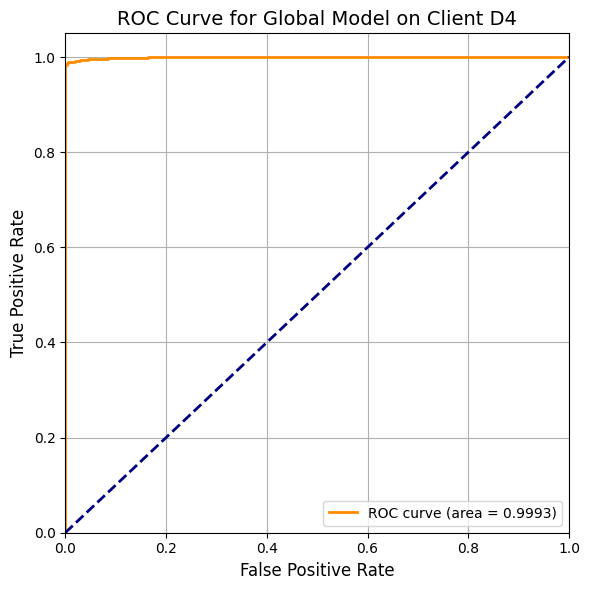


Evaluating final global model on Client D5

Classification Report:
              precision  recall  f1-score  support
NORMAL              1.0     1.0       1.0     50.0
PNEUMONIA           1.0     1.0       1.0     60.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    110.0
weighted avg        1.0     1.0       1.0    110.0


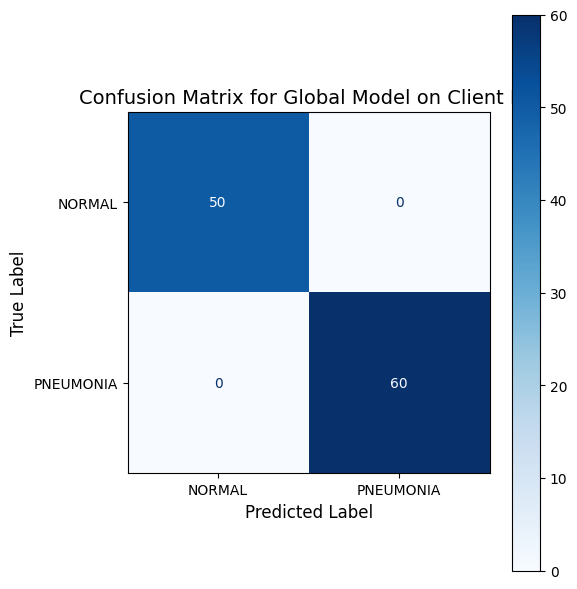

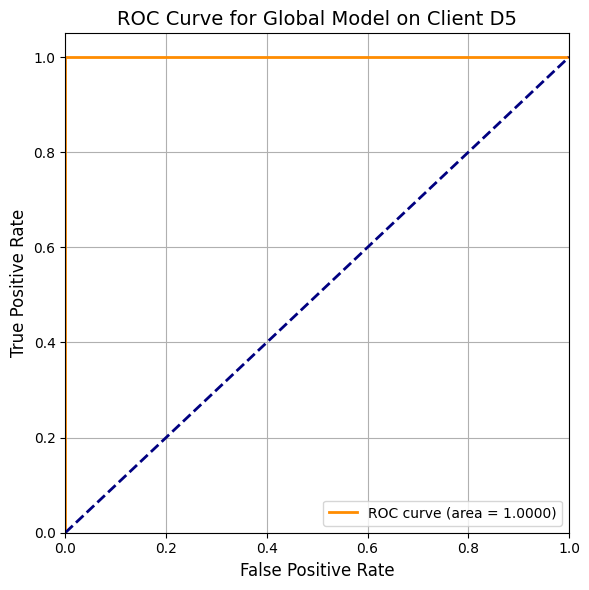


--- Final Federated Evaluation Completed ---

--- Generating All Federated Learning Visualizations and Tables ---

--- Plotting Local Training Metrics for Participating Clients ---


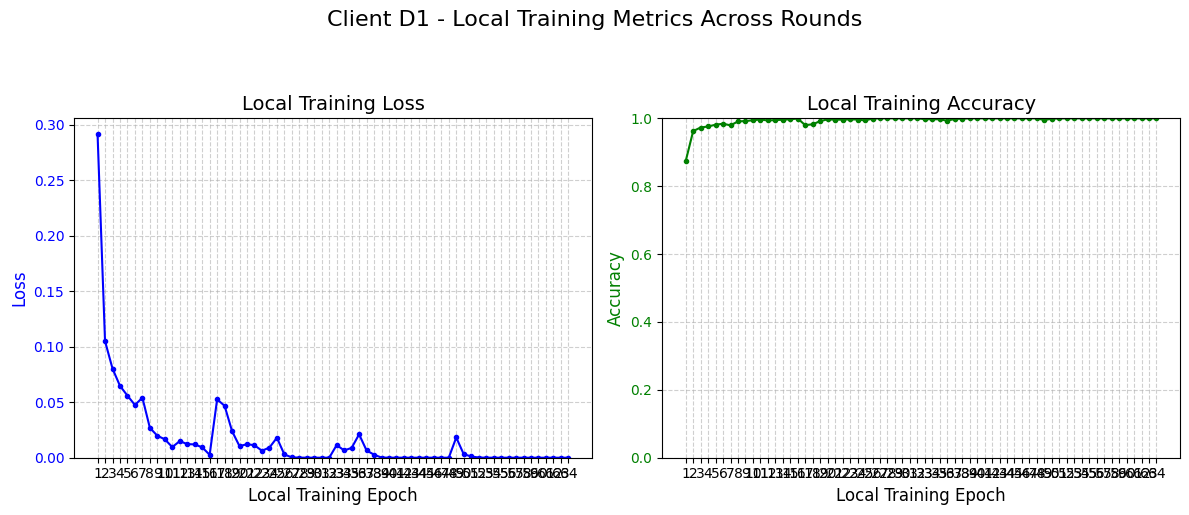

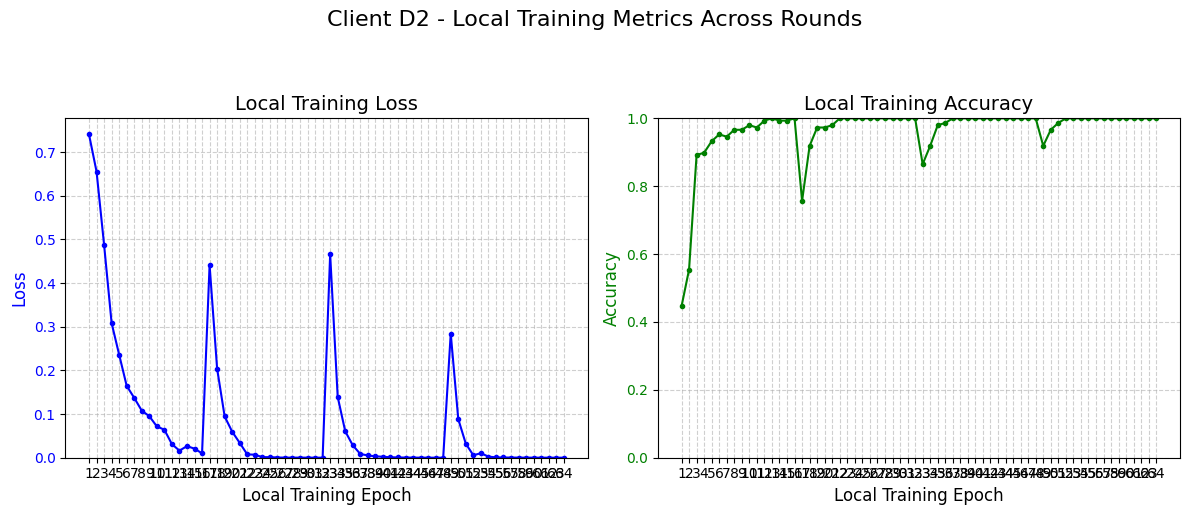

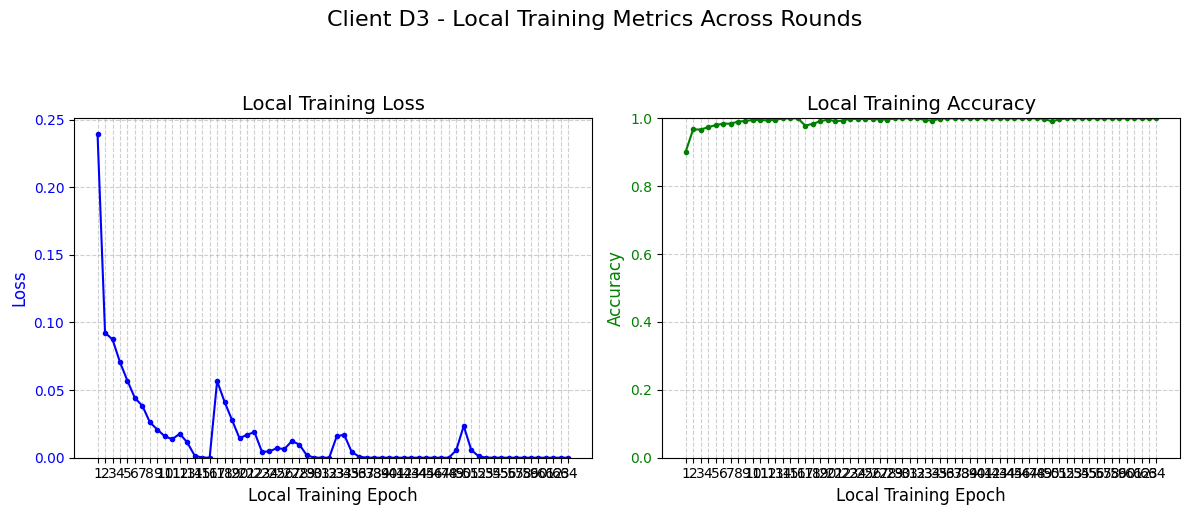

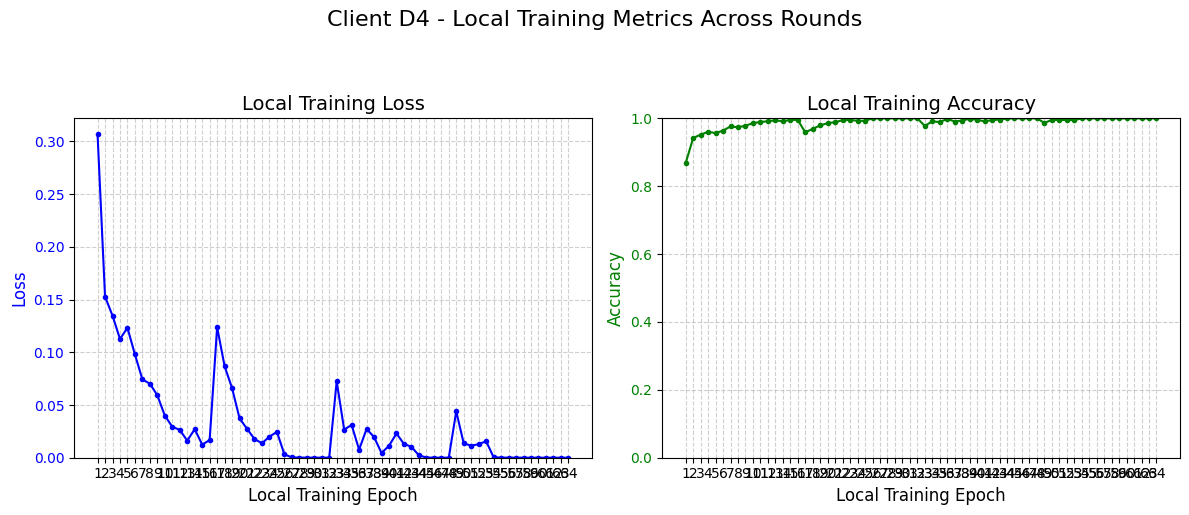

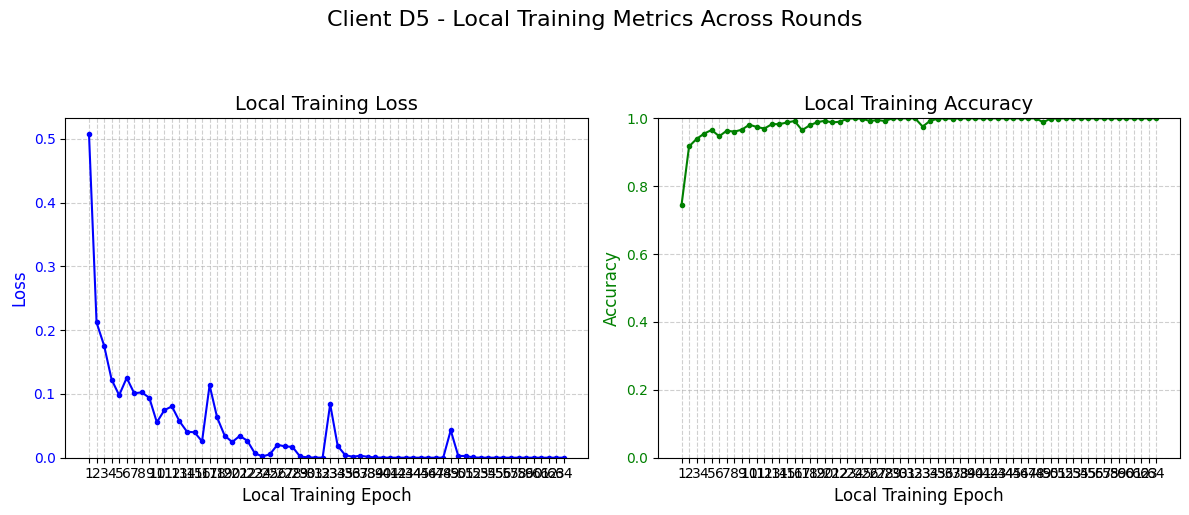


--- Heatmaps for Final Global Model Performance ---


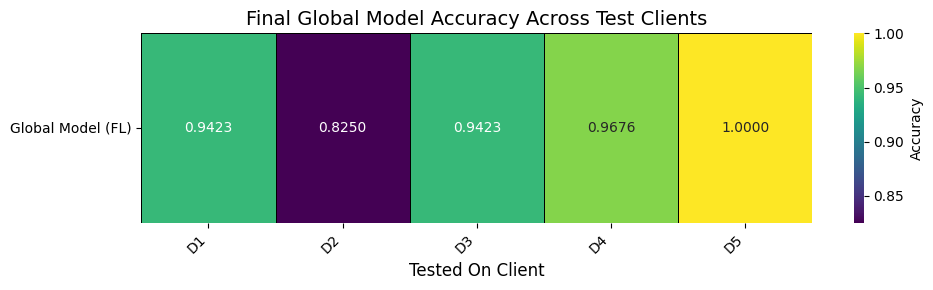

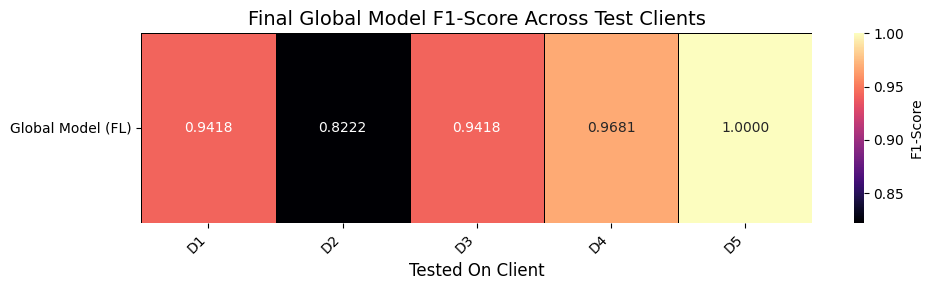

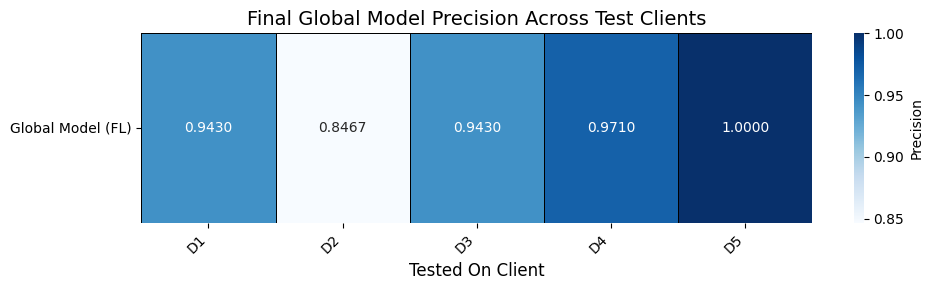

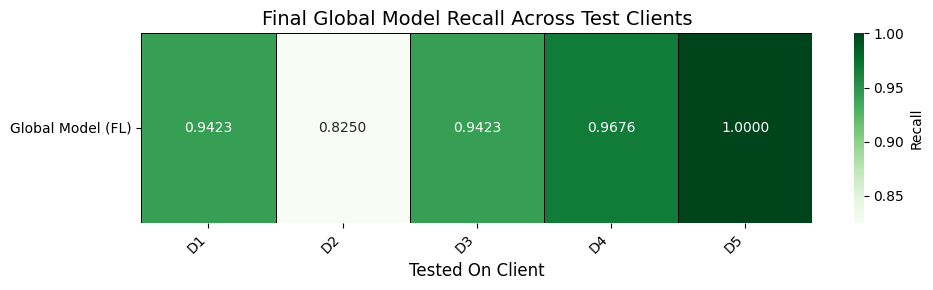

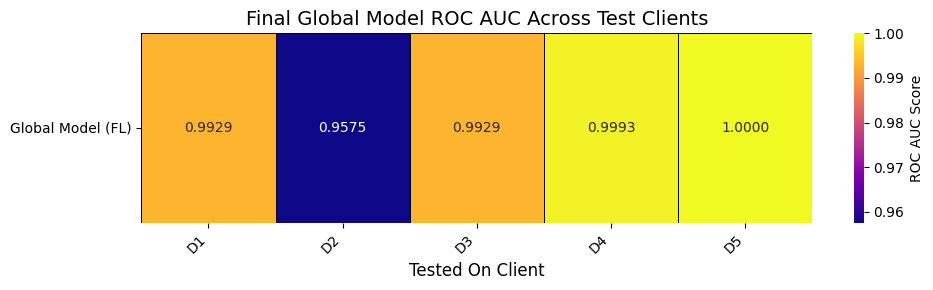


--- Plotting Performance Evolution Over Federated Rounds ---


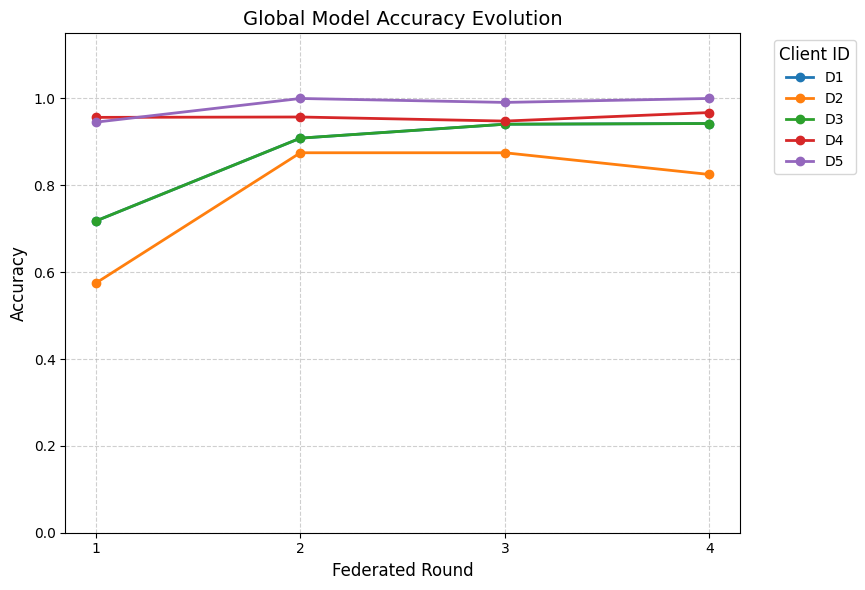

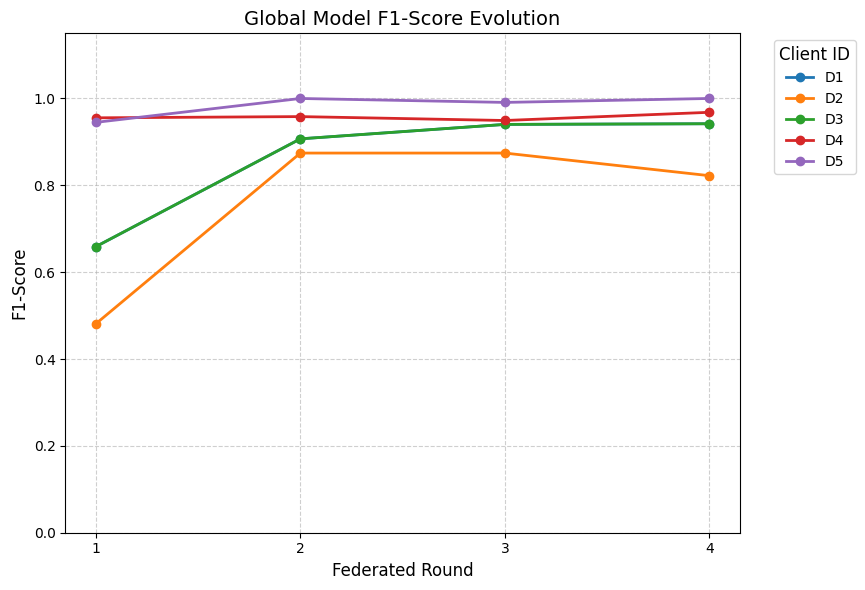

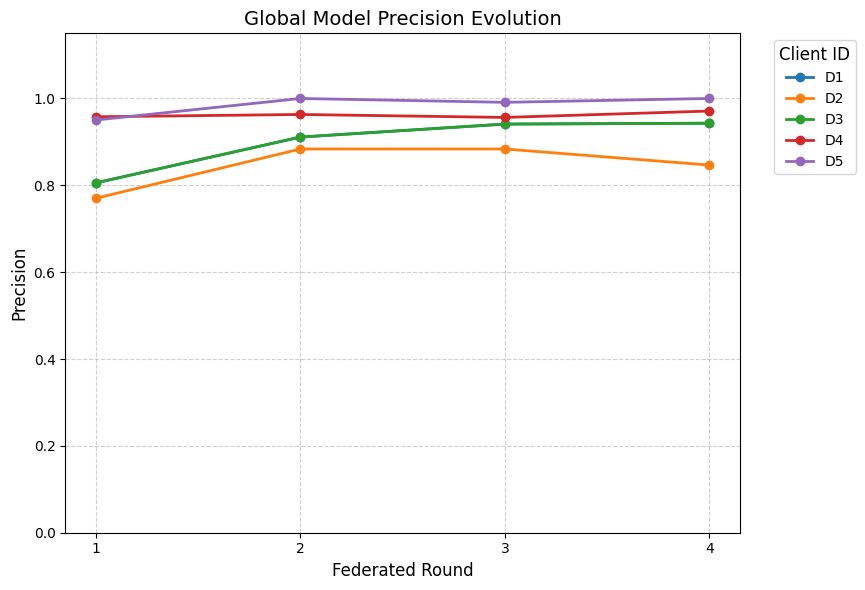

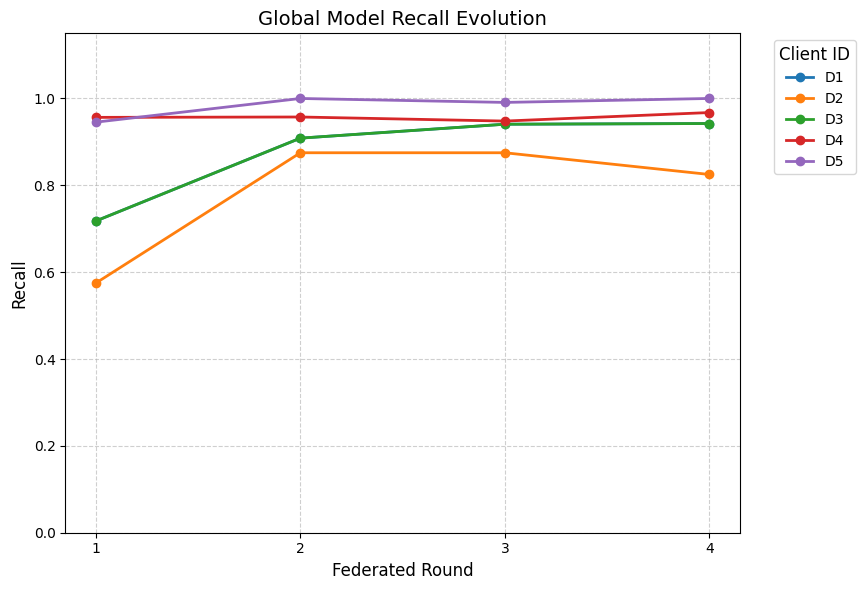

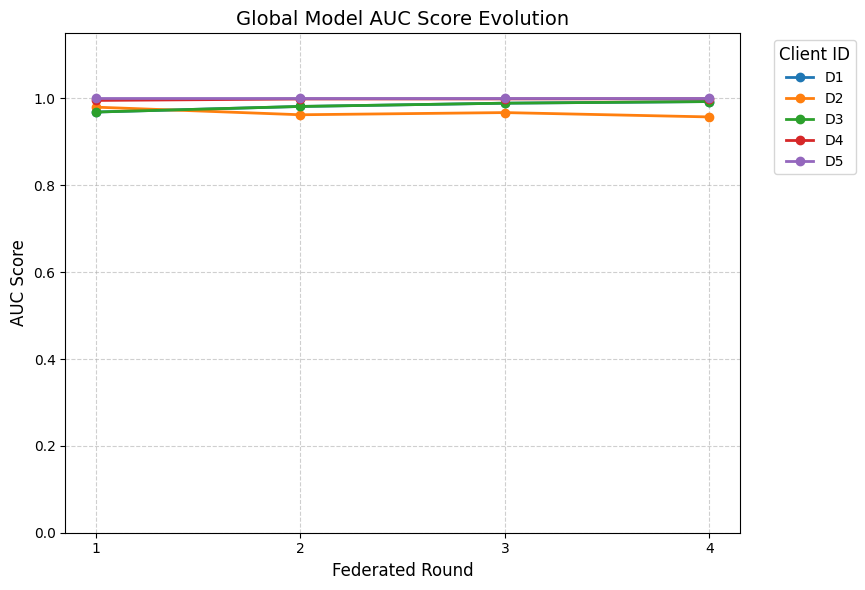


--- Final Performance Bar Charts Per Metric ---


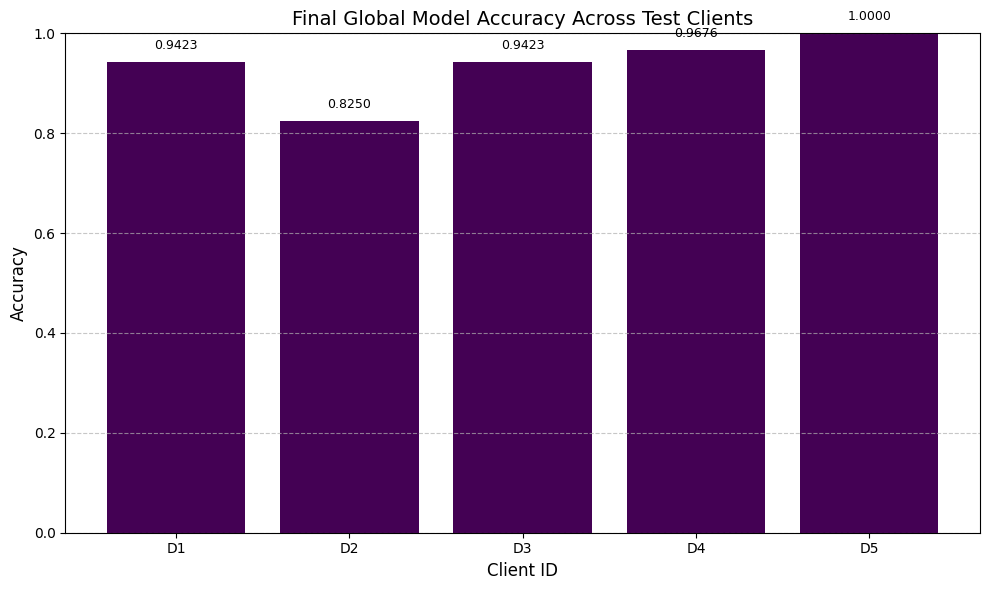

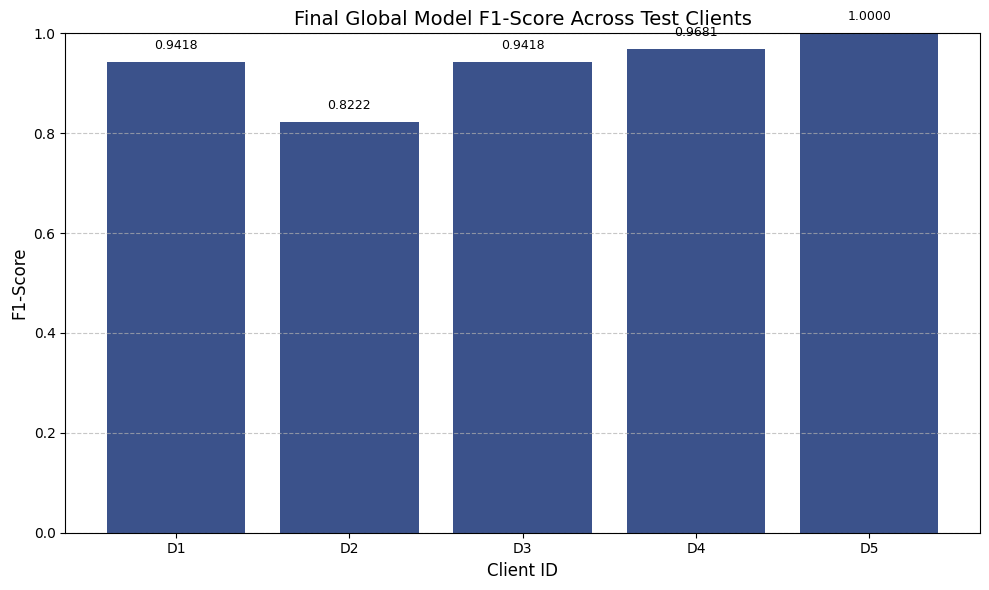

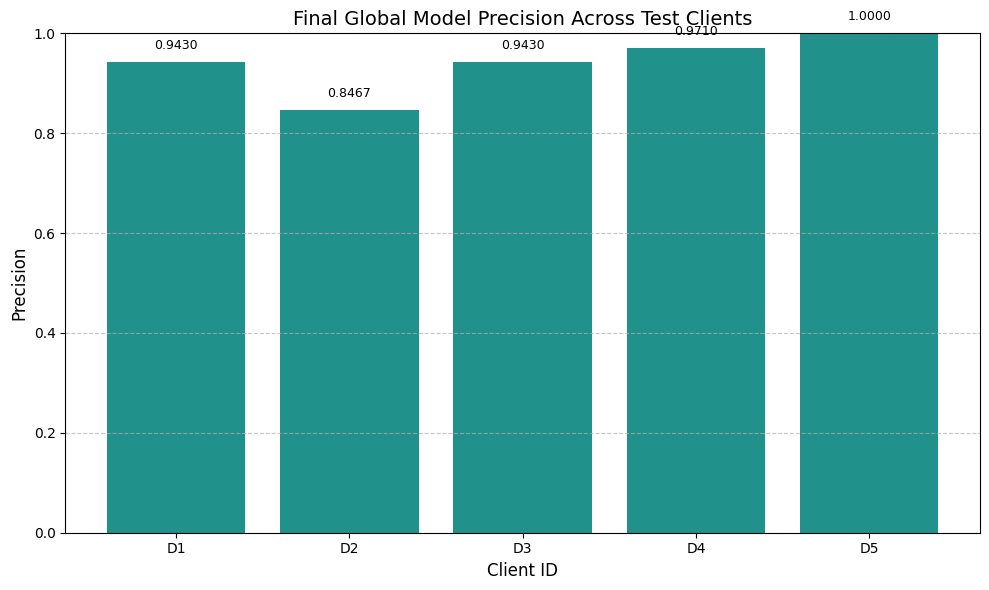

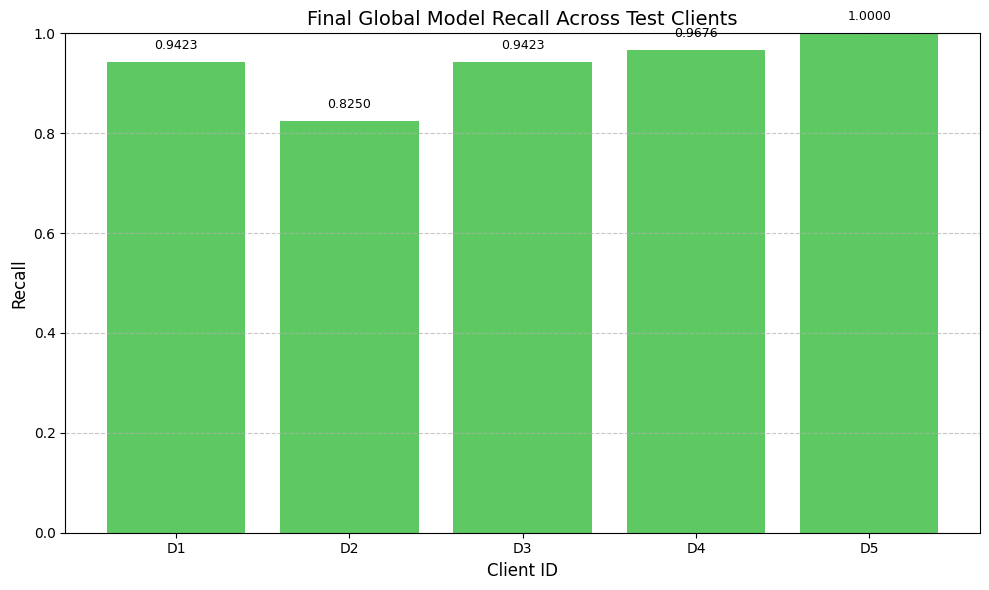

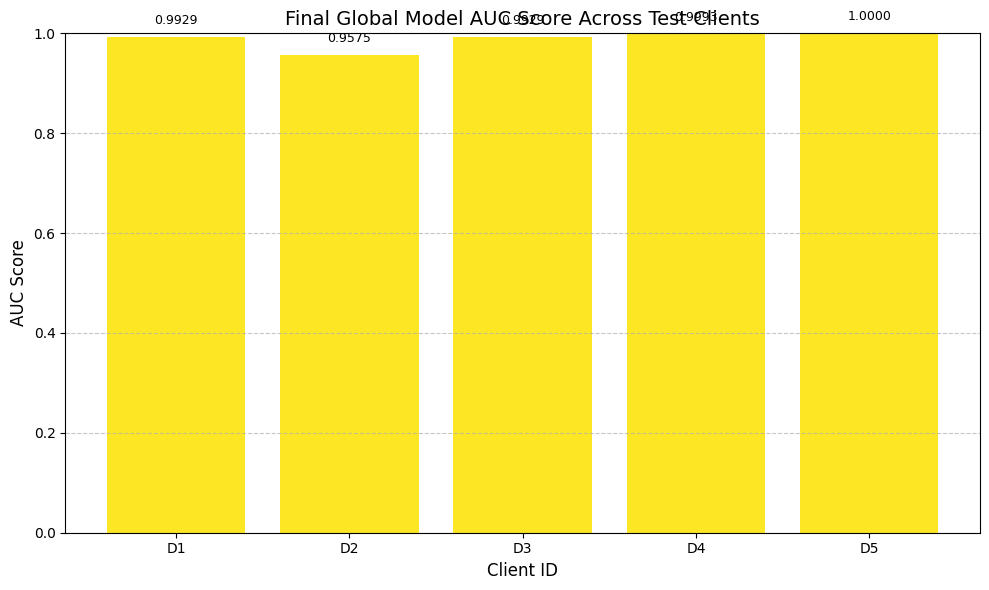


--- All federated learning results and visualizations generated. ---


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image # For displaying sample images

# Force debugging sync
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CONFIG = {
    'rounds': 4,
    'epochs': 16,
    'batch_size': 32,
    'initial_lr': 0.001,
    'num_clients': 5,
}

# --- Dataset Paths ---
train_dataset_paths = {
    "D1": "/kaggle/input/chestxraydataset/chest_xray/train",
    "D2": "/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/train",
    "D3": "/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/train",
    "D4": "/kaggle/input/chest-xray-covid19-pneumonia/Data/train",
    "D5": "/kaggle/input/pneumonia-tuberculosis-normal/Train",
}

# All test paths are included for comprehensive evaluation
test_dataset_paths = {
    "D1": "/kaggle/input/chestxraydataset/chest_xray/test",
    "D2": "/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test",
    "D3": "/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test",
    "D4": "/kaggle/input/chest-xray-covid19-pneumonia/Data/test",
    "D5": "/kaggle/input/pneumonia-tuberculosis-normal/Test",
}

# Define all possible client IDs for consistent indexing in result tables/plots
ALL_CLIENT_IDS = sorted(list(set(list(train_dataset_paths.keys()) + list(test_dataset_paths.keys()))))


# --- Data Transformations ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# --- Function to Load Filtered Dataset ---
def load_filtered_dataset(path):
    """
    Loads an ImageFolder dataset from the given path, filtering for 'NORMAL' and 'PNEUMONIA' classes.
    """
    allowed_classes = ['NORMAL', 'PNEUMONIA']
    try:
        # Check if the path exists and is a directory
        if not os.path.isdir(path):
            print(f"Warning: Dataset path not found or is not a directory: {path}. Returning empty DataLoader.")
            return DataLoader(torch.utils.data.TensorDataset(torch.empty(0)))

        dataset = datasets.ImageFolder(path, transform=transform)
        if not dataset.samples: # Check if the directory is empty of images
             print(f"Warning: No images found in path: {path}. Returning empty DataLoader.")
             return DataLoader(torch.utils.data.TensorDataset(torch.empty(0)))

    except Exception as e:
        print(f"Error loading dataset from path: {path}. Error: {e}. Returning empty DataLoader.")
        return DataLoader(torch.utils.data.TensorDataset(torch.empty(0)))


    class_idx_map = {name: i for i, name in enumerate(allowed_classes)}
    
    filtered_samples = []
    for img_path, label in dataset.samples:
        class_name = dataset.classes[label]
        if class_name in allowed_classes:
            new_label = class_idx_map[class_name]
            filtered_samples.append((img_path, new_label))

    dataset.samples = filtered_samples
    dataset.targets = [label for _, label in filtered_samples]
    dataset.classes = allowed_classes
    dataset.class_to_idx = class_idx_map

    # Use half CPU cores for data loading, ensure at least 1
    num_workers = os.cpu_count() // 2 if os.cpu_count() else 1
    return DataLoader(dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=num_workers)

# --- Simple CNN Model Definition ---
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # Output size: 16 x 112 x 112

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # Output size: 32 x 56 x 56

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # Output size: 64 x 28 x 28
        )
        
        # After three MaxPool2d layers, spatial dimensions are 224 / 2^3 = 28x28
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 2), # 2 classes: NORMAL, PNEUMONIA
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

# --- Local Training Function ---
def train_local_model(model, dataloader):
    model = copy.deepcopy(model)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['initial_lr'])
    loss_fn = nn.CrossEntropyLoss()

    local_losses = []
    local_accuracies = []

    for epoch in range(CONFIG['epochs']):
        epoch_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            output = model(inputs)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(output.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        if total_samples > 0:
            avg_epoch_loss = epoch_loss / total_samples
            avg_epoch_accuracy = correct_predictions / total_samples
        else:
            avg_epoch_loss = float('nan')
            avg_epoch_accuracy = float('nan')

        local_losses.append(avg_epoch_loss)
        local_accuracies.append(avg_epoch_accuracy)

    return model.state_dict(), local_losses, local_accuracies

# --- Detailed Model Evaluation Function ---
def evaluate_model_detailed(model, dataloader):
    model.eval()
    all_preds, all_labels, all_logits = [], [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1) 
            all_preds.extend(preds.cpu().numpy())
            
            # For ROC AUC, we need probabilities of the positive class (PNEUMONIA)
            probabilities = torch.softmax(outputs, dim=1)[:, 1]
            all_logits.extend(probabilities.cpu().numpy())
            
            all_labels.extend(labels.cpu().numpy())
            
    return np.array(all_labels), np.array(all_preds), np.array(all_logits)


# --- Federated Averaging Function ---
def average_weights(weight_list):
    avg_weights = copy.deepcopy(weight_list[0])
    for key in avg_weights.keys():
        for i in range(1, len(weight_list)):
            avg_weights[key] += weight_list[i][key]
        avg_weights[key] = avg_weights[key] / len(weight_list)
    return avg_weights

# --- Function to display sample images ---
def display_sample_images(dataloader, title="Sample Images", num_images=5, model=None, class_names=['NORMAL', 'PNEUMONIA']):
    if len(dataloader.dataset) == 0:
        print(f"No images to display for: {title}")
        return

    plt.figure(figsize=(num_images * 3, 4))
    
    data_iter = iter(dataloader)
    try:
        images, labels = next(data_iter)
    except StopIteration:
        print(f"No images to display for: {title}")
        return


    model_preds = None
    if model:
        model.eval()
        with torch.no_grad():
            outputs = model(images.to(device))
            _, preds = torch.max(outputs, 1)
            model_preds = preds.cpu().numpy()

    for i in range(min(num_images, len(images))):
        ax = plt.subplot(1, num_images, i + 1)
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        
        true_label_name = class_names[labels[i]]
        
        if model_preds is not None:
            pred_label_name = class_names[model_preds[i]]
            title_text = f"True: {true_label_name}\nPred: {pred_label_name}"
            color = 'green' if true_label_name == pred_label_name else 'red'
            plt.title(title_text, color=color, fontsize=10)
        else:
            plt.title(f"True: {true_label_name}", fontsize=10)
        
        plt.axis('off')
    
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --------------- Federated Training Loop ---------------
global_model = SimpleCNN().to(device)

round_accuracies = {client_id: [] for client_id in ALL_CLIENT_IDS}
round_f1_scores = {client_id: [] for client_id in ALL_CLIENT_IDS}
round_precision = {client_id: [] for client_id in ALL_CLIENT_IDS}
round_recall = {client_id: [] for client_id in ALL_CLIENT_IDS}
round_auc_scores = {client_id: [] for client_id in ALL_CLIENT_IDS}

client_training_history = {client_id: {'losses': [], 'accuracies': []} for client_id in train_dataset_paths}


print("--- Starting Federated Training ---")
for rnd in range(CONFIG['rounds']):
    print(f"\n--- Federated Round {rnd+1}/{CONFIG['rounds']} ---")
    local_weights = []

    # --- Client-Side Training ---
    for client_id in train_dataset_paths:
        print(f"  Training client {client_id}...")
        train_loader = load_filtered_dataset(train_dataset_paths[client_id])
        if len(train_loader.dataset) == 0:
            print(f"    Client {client_id} has no training data after filtering. Skipping.")
            continue
            
        local_model_weights, local_losses, local_accuracies = train_local_model(global_model, train_loader)
        local_weights.append(local_model_weights)
        
        client_training_history[client_id]['losses'].append(local_losses)
        client_training_history[client_id]['accuracies'].append(local_accuracies)

    if not local_weights:
        print("No clients participated in this round due to empty datasets. Exiting training.")
        break
        
    # --- Server-Side Aggregation ---
    print("  Aggregating client models...")
    avg_weights = average_weights(local_weights)
    global_model.load_state_dict(avg_weights)

    # --- Evaluation After Each Round ---
    print("  Evaluating global model on test sets after aggregation...")
    for client_id in test_dataset_paths:
        test_loader = load_filtered_dataset(test_dataset_paths[client_id])
        if len(test_loader.dataset) == 0:
            print(f"    Test dataset {client_id} is empty. Skipping evaluation.")
            round_accuracies[client_id].append(np.nan)
            round_f1_scores[client_id].append(np.nan)
            round_precision[client_id].append(np.nan)
            round_recall[client_id].append(np.nan)
            round_auc_scores[client_id].append(np.nan)
            continue
            
        true_labels, predictions, logits = evaluate_model_detailed(global_model, test_loader)
        
        report = classification_report(true_labels, predictions, target_names=['NORMAL', 'PNEUMONIA'], output_dict=True, zero_division=0)
        
        acc = report['accuracy']
        f1 = report['weighted avg']['f1-score']
        prec = report['weighted avg']['precision']
        rec = report['weighted avg']['recall']
        
        roc_auc = np.nan
        try:
            if len(np.unique(true_labels)) > 1:
                fpr, tpr, _ = roc_curve(true_labels, logits)
                roc_auc = auc(fpr, tpr)
        except ValueError:
            # This handles cases where roc_curve might fail for other reasons
            pass

        round_accuracies[client_id].append(acc)
        round_f1_scores[client_id].append(f1)
        round_precision[client_id].append(prec)
        round_recall[client_id].append(rec)
        round_auc_scores[client_id].append(roc_auc)
        print(f"    Client Test Dataset {client_id} - Acc: {acc:.4f}, F1: {f1:.4f}, AUC: {roc_auc if not np.isnan(roc_auc) else 'N/A'}")

print("\n--- Federated Training Completed ---")

# --------------- Final Evaluation with Detailed Metrics and Visualizations ---------------
print("\n--- Final Evaluation on Each Client with Detailed Metrics and Visualizations ---")

final_metrics_accuracies = pd.DataFrame(index=['Global Model (FL)'], columns=ALL_CLIENT_IDS, dtype=float)
final_metrics_f1_scores = pd.DataFrame(index=['Global Model (FL)'], columns=ALL_CLIENT_IDS, dtype=float)
final_metrics_precision = pd.DataFrame(index=['Global Model (FL)'], columns=ALL_CLIENT_IDS, dtype=float)
final_metrics_recall = pd.DataFrame(index=['Global Model (FL)'], columns=ALL_CLIENT_IDS, dtype=float)
final_metrics_auc_scores = pd.DataFrame(index=['Global Model (FL)'], columns=ALL_CLIENT_IDS, dtype=float)


for client_id in ALL_CLIENT_IDS:
    print(f"\nEvaluating final global model on Client {client_id}")
    test_loader = load_filtered_dataset(test_dataset_paths[client_id])
    
    if len(test_loader.dataset) == 0:
        print(f"  Test dataset {client_id} is empty. Skipping detailed evaluation.")
        final_metrics_accuracies.loc['Global Model (FL)', client_id] = np.nan
        final_metrics_f1_scores.loc['Global Model (FL)', client_id] = np.nan
        final_metrics_precision.loc['Global Model (FL)', client_id] = np.nan
        final_metrics_recall.loc['Global Model (FL)', client_id] = np.nan
        final_metrics_auc_scores.loc['Global Model (FL)', client_id] = np.nan
        continue
        
    global_model.eval()
    true_labels, predictions, logits = evaluate_model_detailed(global_model, test_loader)

    print("\nClassification Report:")
    report = classification_report(true_labels, predictions, target_names=['NORMAL', 'PNEUMONIA'], digits=4, output_dict=True, zero_division=0)
    
    df_report = pd.DataFrame(report).transpose()
    print(df_report.to_string())

    final_metrics_accuracies.loc['Global Model (FL)', client_id] = report['accuracy']
    final_metrics_f1_scores.loc['Global Model (FL)', client_id] = report['weighted avg']['f1-score']
    final_metrics_precision.loc['Global Model (FL)', client_id] = report['weighted avg']['precision']
    final_metrics_recall.loc['Global Model (FL)', client_id] = report['weighted avg']['recall']
    
    roc_auc = np.nan
    try:
        if len(np.unique(true_labels)) > 1:
            fpr, tpr, _ = roc_curve(true_labels, logits)
            roc_auc = auc(fpr, tpr)
        else:
            print(f"    Warning: Only one class present in {client_id} for ROC AUC calculation. Setting AUC to NaN.")
    except ValueError as e:
        print(f"    Warning: Could not calculate ROC AUC for {client_id} due to data issues: {e}. Setting AUC to NaN.")

    final_metrics_auc_scores.loc['Global Model (FL)', client_id] = roc_auc

    # --- Confusion Matrix ---
    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
    ax.set_title(f'Confusion Matrix for Global Model on Client {client_id}', fontsize=14)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

    # --- ROC Curve ---
    if not np.isnan(roc_auc):
        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(f'ROC Curve for Global Model on Client {client_id}', fontsize=14)
        plt.legend(loc="lower right", fontsize=10)
        plt.grid(True)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        plt.show()

print("\n--- Final Federated Evaluation Completed ---")

# --------------- Overall Results Summary and Visualizations ---------------
print("\n--- Generating All Federated Learning Visualizations and Tables ---")

# --- 1. Client-Side Training Loss and Accuracy Curves ---
print("\n--- Plotting Local Training Metrics for Participating Clients ---")
for client_id, history in client_training_history.items():
    # CORRECTED SECTION: Flatten the list of lists first, then check.
    flat_losses = [loss for round_losses in history['losses'] for loss in round_losses]
    
    if not flat_losses or all(pd.isna(l) for l in flat_losses):
        print(f"  No training history available for client {client_id}. Skipping plot.")
        continue

    flat_accuracies = [acc for round_accuracies in history['accuracies'] for acc in round_accuracies]
    
    # Calculate the effective number of training steps (epochs * rounds client participated in)
    total_training_steps = len(flat_losses)

    if total_training_steps == 0:
        continue

    plt.figure(figsize=(12, 5))
    
    # Subplot for Loss
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(range(1, total_training_steps + 1), flat_losses, marker='.', color='blue', label='Training Loss')
    ax1.set_xlabel('Local Training Epoch', fontsize=12)
    ax1.set_ylabel('Loss', color='blue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='blue', labelsize=10)
    ax1.tick_params(axis='x', labelsize=10)
    ax1.set_title(f'Local Training Loss', fontsize=14)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_xticks(range(1, total_training_steps + 1))
    ax1.set_ylim(bottom=0)

    # Subplot for Accuracy
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(range(1, total_training_steps + 1), flat_accuracies, marker='.', color='green', label='Training Accuracy')
    ax2.set_xlabel('Local Training Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', color='green', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='green', labelsize=10)
    ax2.tick_params(axis='x', labelsize=10)
    ax2.set_title(f'Local Training Accuracy', fontsize=14)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.set_xticks(range(1, total_training_steps + 1))
    ax2.set_ylim(0, 1)

    plt.suptitle(f'Client {client_id} - Local Training Metrics Across Rounds', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# --- 2. Heatmaps for Final Global Model Performance ---
print("\n--- Heatmaps for Final Global Model Performance ---")

def plot_heatmap(data, title, cmap, label):
    plt.figure(figsize=(10, 3))
    sns.heatmap(data, annot=True, fmt=".4f", cmap=cmap,
                cbar_kws={'label': label}, linewidths=.5, linecolor='black',
                annot_kws={"size": 10})
    plt.title(title, fontsize=14)
    plt.xlabel('Tested On Client', fontsize=12)
    plt.ylabel('', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

plot_heatmap(final_metrics_accuracies, 'Final Global Model Accuracy Across Test Clients', "viridis", "Accuracy")
plot_heatmap(final_metrics_f1_scores, 'Final Global Model F1-Score Across Test Clients', "magma", "F1-Score")
plot_heatmap(final_metrics_precision, 'Final Global Model Precision Across Test Clients', "Blues", "Precision")
plot_heatmap(final_metrics_recall, 'Final Global Model Recall Across Test Clients', "Greens", "Recall")
plot_heatmap(final_metrics_auc_scores, 'Final Global Model ROC AUC Across Test Clients', "plasma", "ROC AUC Score")


# --- 3. Performance Evolution Over Federated Rounds ---
print("\n--- Plotting Performance Evolution Over Federated Rounds ---")

metrics_to_plot = {
    'Accuracy': round_accuracies,
    'F1-Score': round_f1_scores,
    'Precision': round_precision,
    'Recall': round_recall,
    'AUC Score': round_auc_scores,
}

for metric_name, metric_data in metrics_to_plot.items():
    plt.figure(figsize=(10, 6))
    for client_id, values in metric_data.items():
        if any(not pd.isna(val) for val in values):
            plt.plot(range(1, CONFIG['rounds'] + 1), values, marker='o', linestyle='-', label=f'{client_id}', lw=2)

    plt.xlabel('Federated Round', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.title(f'Global Model {metric_name} Evolution', fontsize=14)
    plt.legend(title="Client ID", bbox_to_anchor=(1.04, 1), loc='upper left', fontsize=10, title_fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(range(1, CONFIG['rounds'] + 1), fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylim(0, 1.15)
    plt.tight_layout(rect=[0, 0, 0.88, 1])
    plt.show()


# --- 4. Final Performance Bar Charts per Metric ---
print("\n--- Final Performance Bar Charts Per Metric ---")

df_final_metrics = pd.DataFrame({
    'Accuracy': final_metrics_accuracies.loc['Global Model (FL)'],
    'F1-Score': final_metrics_f1_scores.loc['Global Model (FL)'],
    'Precision': final_metrics_precision.loc['Global Model (FL)'],
    'Recall': final_metrics_recall.loc['Global Model (FL)'],
    'AUC Score': final_metrics_auc_scores.loc['Global Model (FL)'],
}).transpose()

# Using a modern way to get colormaps
cmap = plt.colormaps.get('viridis')
colors = cmap(np.linspace(0, 1, len(df_final_metrics.index)))

for i, metric_name in enumerate(df_final_metrics.index):
    plt.figure(figsize=(10, 6))
    plot_data = df_final_metrics.loc[metric_name].dropna()
    if plot_data.empty:
        print(f"  No valid data to plot for final {metric_name}.")
        plt.close()
        continue

    bars = plt.bar(plot_data.index, plot_data.values, color=colors[i])
    plt.xlabel('Client ID', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.title(f'Final Global Model {metric_name} Across Test Clients', fontsize=14)
    plt.ylim(0, 1)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    for bar in bars:
        yval = bar.get_height()
        if not pd.isna(yval):
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=9)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


print("\n--- All federated learning results and visualizations generated. ---")